# Airbnb Price Prediction

## Loading & Preparing

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MultiLabelBinarizer

from sklearn.model_selection import (
    train_test_split, GroupKFold, GroupShuffleSplit, GridSearchCV
)
from sklearn.utils import shuffle

from sklearn.cluster import KMeans

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

import folium

import shap

In [56]:
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing')

In [57]:
data = pd.read_csv("listings.csv")
data.shape[0]

44684

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44684 entries, 0 to 44683
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            44684 non-null  int64  
 1   listing_url                                   44684 non-null  object 
 2   scrape_id                                     44684 non-null  int64  
 3   last_scraped                                  44684 non-null  object 
 4   source                                        44684 non-null  object 
 5   name                                          44683 non-null  object 
 6   description                                   43349 non-null  object 
 7   neighborhood_overview                         23839 non-null  object 
 8   picture_url                                   44684 non-null  object 
 9   host_id                                       44684 non-null 

## Preprocessing

#### Seperating Columns

In [59]:
non_essential_features = [
    "id", "listing_url", "scrape_id", "last_scraped", "source", "picture_url", "host_id", 
    "host_url", "host_thumbnail_url", "host_picture_url", "license", "calendar_updated", 
    "calendar_last_scraped", "host_listings_count", "host_location", 
    "neighbourhood", "host_neighbourhood", "neighbourhood_group_cleansed",
    "bathrooms_text", "maximum_minimum_nights", "maximum_maximum_nights", 
    "minimum_nights_avg_ntm", "minimum_maximum_nights", "maximum_nights_avg_ntm", "calculated_host_listings_count", 
    "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", 
    "calculated_host_listings_count_shared_rooms", "number_of_reviews_ltm", "reviews_per_month", 
    "number_of_reviews_l30d", "host_acceptance_rate", "name", "description", "neighborhood_overview", 
    "host_name", "host_about", "host_has_profile_pic", "host_total_listings_count", "host_identity_verified", "bedrooms"
]

continuous_features_std = [
    "number_of_reviews", "first_review", "last_review", "host_since"
] 

continuous_features_minmax = [
    "accommodates", "bathrooms", "beds", "availability_30", "availability_60", 
    "availability_90", "availability_365", "review_scores_accuracy", "review_scores_cleanliness", 
    "review_scores_checkin", "review_scores_communication", "review_scores_value", 
    "review_scores_rating", "review_scores_location", "host_response_rate"
]

categorical_features = [
    "has_availability", "instant_bookable", "host_is_superhost", 
    "property_type", "room_type", "neighbourhood_cleansed", "host_response_time"
]

multi_label_features = [
    "host_verifications", "amenities"
]

target = "price"

#### Adding Amenities Count

In [60]:
aminities_count = []
for i in data['amenities']:
  aminities_count.append(len(i))

data['amenities_count'] = aminities_count

print(data['amenities_count'])

0         479
1        1583
2        1203
3         287
4         574
         ... 
44679     190
44680     314
44681     243
44682     257
44683     133
Name: amenities_count, Length: 44684, dtype: int64


#### Converting Columns & Lists to Appropriate Data Types

In [61]:
data[categorical_features] = data[categorical_features].astype(str)

columns_to_clean = {
    "price": {
        "replace": r"[$,]",
        "regex": True,
        "convert": float
    },
    "host_verifications": {
        "replace": r"[\'\[\]]",
        "regex": True,
        "lowercase": True,
        "split": ","
    },
    "amenities": {
        "replace": r"[{}\"]",
        "regex": True,
        "lowercase": True,
        "split": ","
    },
    "host_response_rate": {
        "replace": r"%",
        "regex": False, 
        "convert": float  
    }
}

def clean_columns(data, columns_to_clean):
    for col, params in columns_to_clean.items():
        if col in data.columns:
            if "replace" in params:
                data[col] = data[col].astype(str).str.replace(
                    params["replace"], 
                    "", 
                    regex=params.get("regex", True)
                )
            if params.get("lowercase", False):
                data[col] = data[col].str.lower()
            if params.get("split", False):
                data[col] = data[col].str.split(params["split"])
            if "convert" in params:
                data[col] = data[col].astype(params["convert"])
    return data

data = clean_columns(data, columns_to_clean)

In [62]:
mlb = MultiLabelBinarizer()  
host_verif_matrix = mlb.fit_transform(data['host_verifications']) 
host_verif_df = pd.DataFrame(host_verif_matrix, columns=mlb.classes_, index=data.index)

amenities_matrix = mlb.fit_transform(data['amenities'])
amenities_df = pd.DataFrame(amenities_matrix, columns = mlb.classes_, index=data.index)
amenities_df = amenities_df.loc[:, ~amenities_df.columns.duplicated()]

top = amenities_df.sum().sort_values(ascending=False).head(100).index
amenities_df = amenities_df[top]
data = data.drop(['host_verifications', 'amenities'], axis=1)
data = pd.concat([data, amenities_df, host_verif_df], axis=1)
data = data.drop(['nan', ''], axis=1)

#### Converting date features

In [63]:
dt_cols = ['host_since', 'first_review', 'last_review']

data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)

today = pd.to_datetime('today')
dt_days_df = data[dt_cols].apply(lambda col: (today - col).dt.days)

dt_days_df.columns = [f"{col}" for col in dt_cols]

data = pd.concat([data.drop(columns=dt_cols), dt_days_df], axis=1)

C:\Users\mdall\AppData\Local\Temp\ipykernel_5932\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)
C:\Users\mdall\AppData\Local\Temp\ipykernel_5932\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[dt_cols] = data[dt_cols].apply(pd.to_datetime, infer_datetime_format=True)
C:\Users\mdall\AppData\Local\Temp\ipykernel_5932\2911844311.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A stric

#### Transforming price to log price

In [64]:
data_nologprice = data.copy()
data['price'] = np.log(data['price'])

#### Dropping non relevant features and missing target variables

In [65]:
data = data.drop(columns = non_essential_features)
data = data.dropna(subset=['price'])

#### Adding New Groups

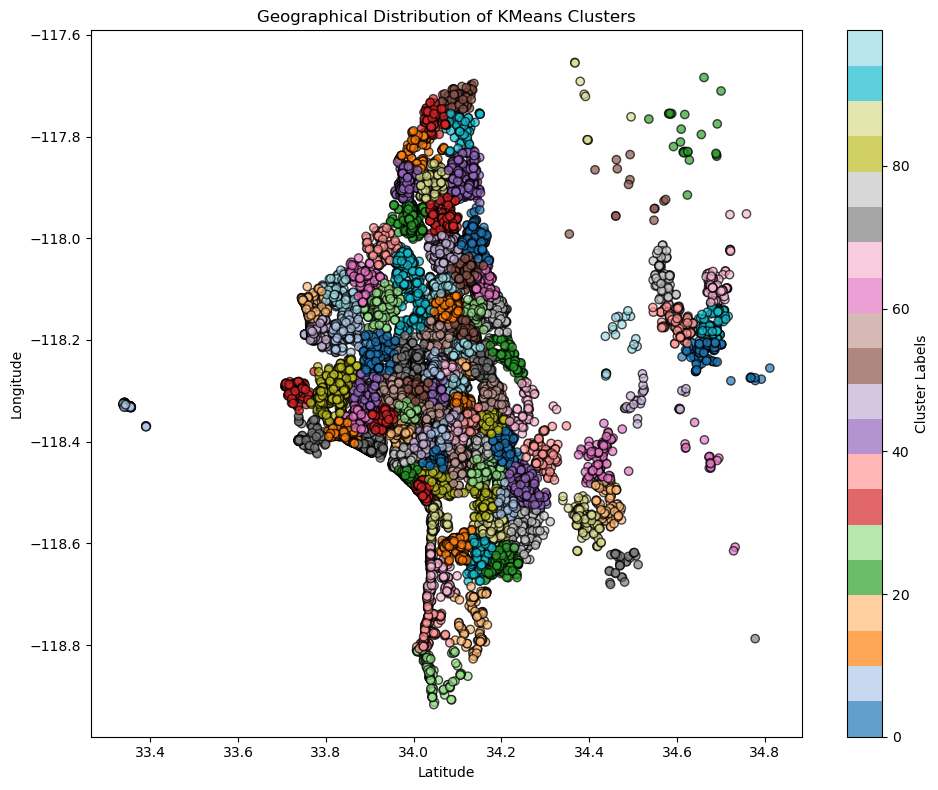

In [66]:
n_clusters = 100

latitude_col = 'latitude'
longitude_col = 'longitude'
coords = data[[latitude_col, longitude_col]]

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(coords)

data['kmeans_group'] = cluster_labels

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    coords[latitude_col], coords[longitude_col], 
    c=cluster_labels, cmap='tab20', alpha=0.7, edgecolor='k'
)
plt.colorbar(scatter, label='Cluster Labels')
plt.title("Geographical Distribution of KMeans Clusters")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.tight_layout()
plt.show()

data_eda = data.copy()
data = data.drop(columns = [longitude_col, latitude_col])

#### Setting up variables

In [67]:
X = data.drop(columns=["price"])
y = data["price"]
groups = data["kmeans_group"]

## EDA

#### General Dataset

In [68]:
total_missing_rows = data[data.isnull().any(axis=1)].shape[0]

print(total_missing_rows)

11329


In [69]:
num_rows = data.shape[0]
num_columns = data.shape[1]
column_names = data.columns.tolist()
missing_values = data.isnull().sum()
missing_percentage = (missing_values / num_rows) * 100

print('Data dimensions:', data.shape)

perc_missing_per_ftr = data.isnull().sum(axis=0) / data.shape[0]
print('Fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data types of the features with missing values:')
print(data[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(data.isnull().sum(axis=1) != 0) / data.shape[0]
print('Fraction of points with missing values:', frac_missing)

Data dimensions: (36540, 137)
Fraction of missing values in features:
host_response_rate             0.110290
bathrooms                      0.000301
beds                           0.003941
review_scores_rating           0.252490
review_scores_accuracy         0.253612
review_scores_cleanliness      0.253612
review_scores_checkin          0.253722
review_scores_communication    0.253612
review_scores_location         0.253722
review_scores_value            0.253749
first_review                   0.252490
last_review                    0.252490
dtype: float64
Data types of the features with missing values:
host_response_rate             float64
bathrooms                      float64
beds                           float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float

#### Target

In [70]:
# Calculate statistics for the untransformed price
min_price = data_nologprice['price'].min()
max_price = data_nologprice['price'].max()
avg_price = data_nologprice['price'].mean()

# Display the results
print(f"Price ranged from {min_price:.2f} to {max_price:.2f} with an average price of {avg_price:.2f}.")

Price ranged from 6.00 to 99999.00 with an average price of 317.20.


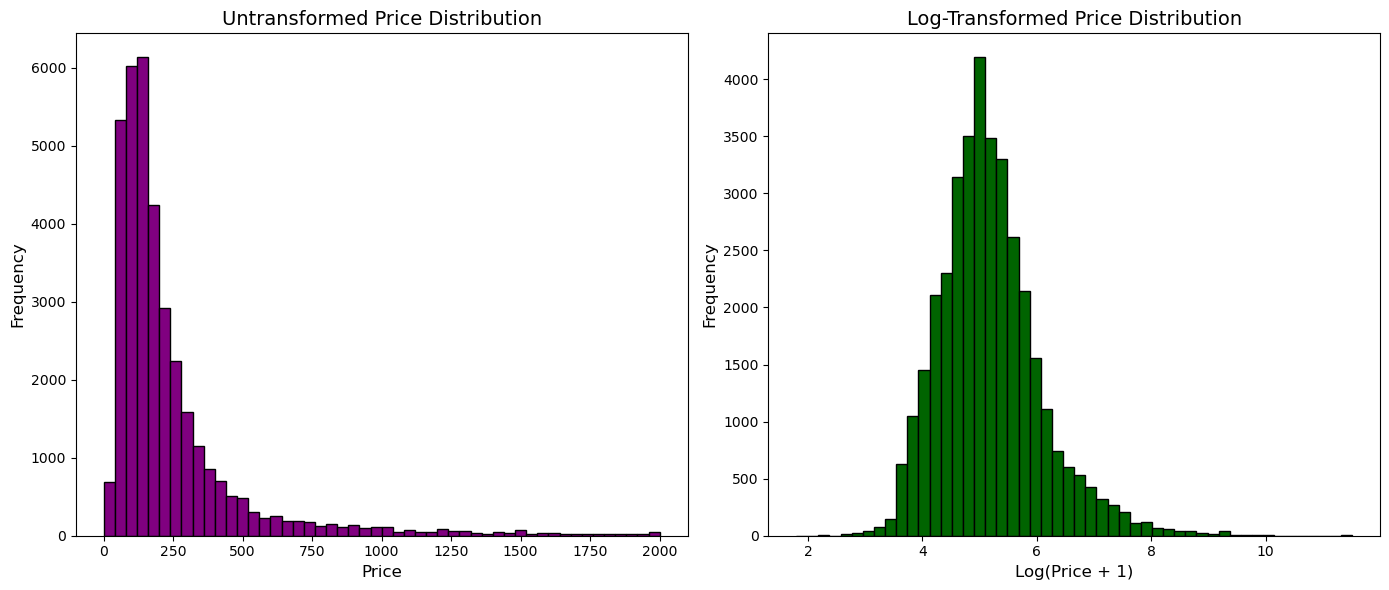

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(data_nologprice["price"], bins=50, color='purple', edgecolor='black', range=(0, 2000))
axes[0].set_title('Untransformed Price Distribution', fontsize=14)
axes[0].set_xlabel('Price', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(False) 

axes[1].hist(data['price'], bins=50, color='darkgreen', edgecolor='black')
axes[1].set_title('Log-Transformed Price Distribution', fontsize=14)
axes[1].set_xlabel('Log(Price + 1)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(False)  

plt.tight_layout()
plt.show()

#### Price Vs Property Characteristics

C:\Users\mdall\AppData\Local\Temp\ipykernel_5932\3644581570.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)


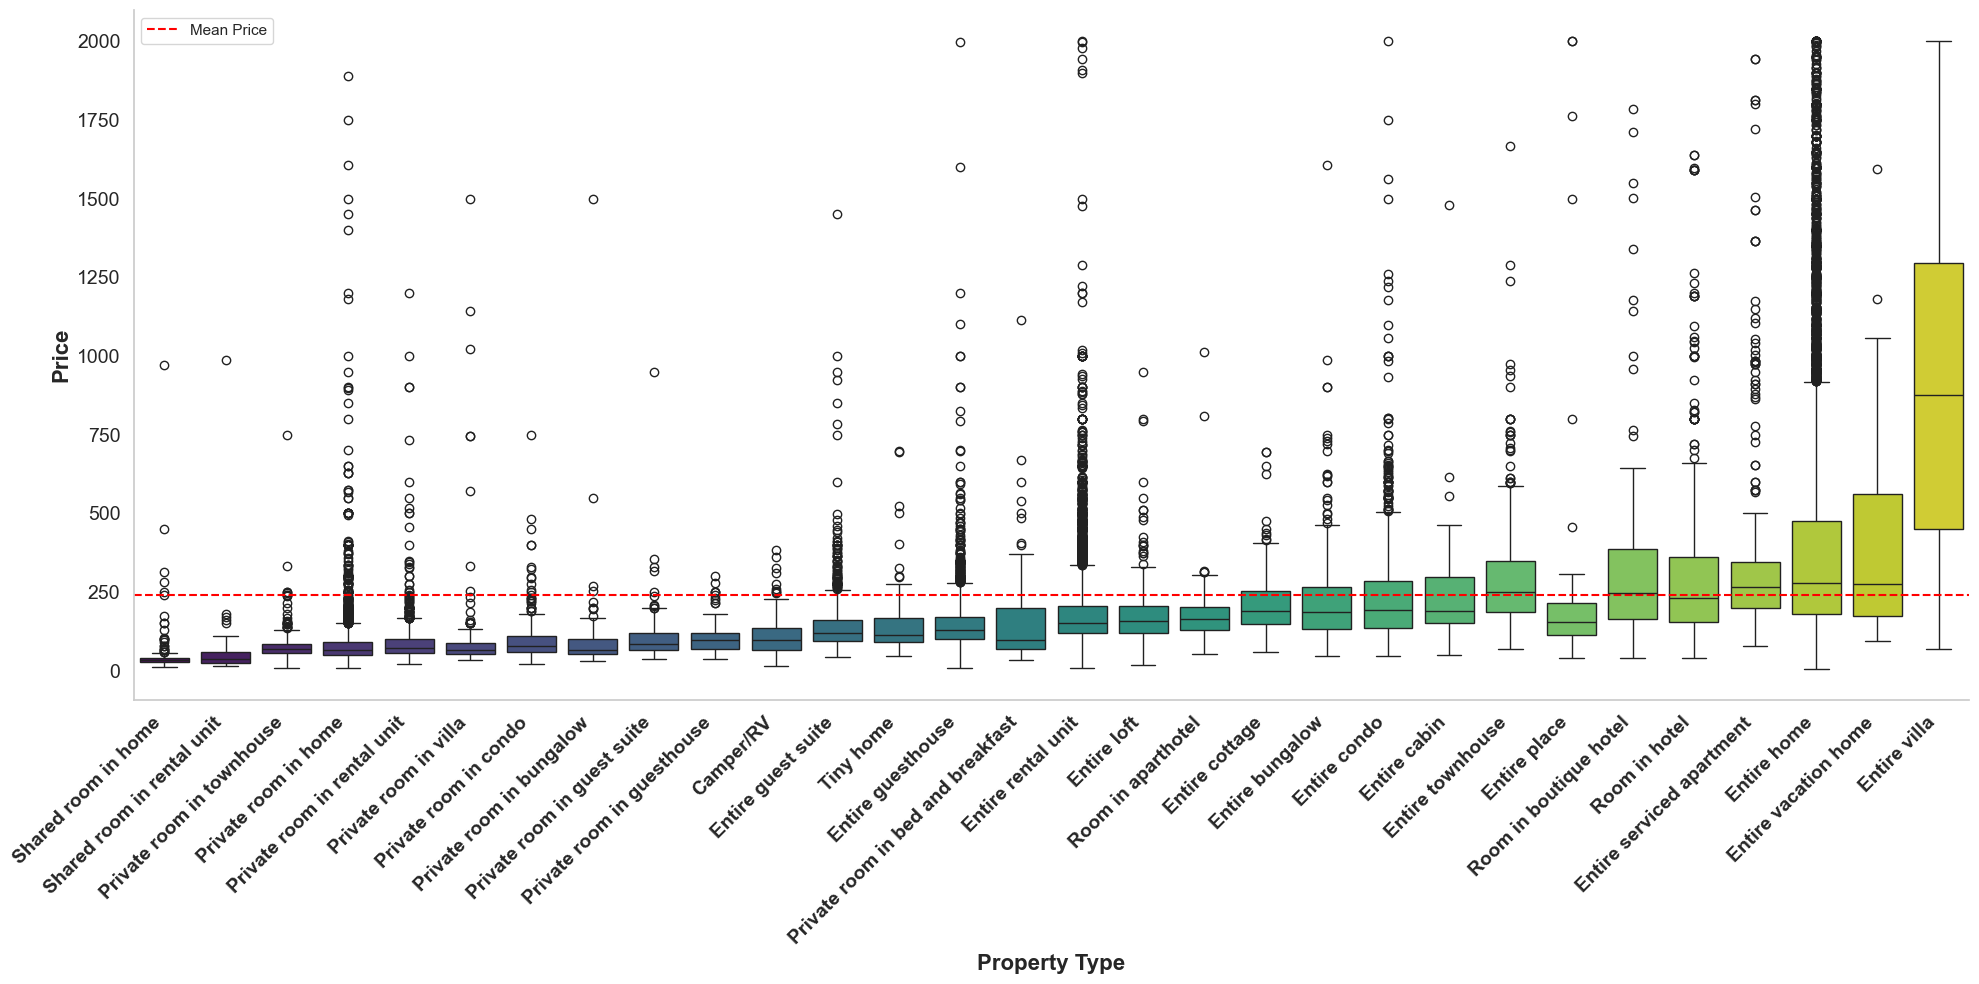

Top 30 Most Common Property Types:
property_type
Entire home                          10513
Entire rental unit                    9325
Private room in home                  4523
Entire guesthouse                     2384
Entire condo                          1458
Private room in rental unit           1209
Entire guest suite                    1110
Entire townhouse                       615
Entire villa                           481
Entire bungalow                        426
Entire serviced apartment              420
Room in hotel                          393
Private room in townhouse              343
Private room in condo                  339
Entire loft                            260
Private room in villa                  220
Shared room in home                    186
Private room in guest suite            169
Room in boutique hotel                 165
Tiny home                              144
Entire cottage                         139
Private room in bed and breakfast      139
Campe

In [72]:
sns.set(style='whitegrid', palette='muted')

filtered_data = data_nologprice[(data_nologprice["price"] >= 0) & (data_nologprice["price"] <= 2000)]

top_property_types = filtered_data['property_type'].value_counts().nlargest(30).index

top_filtered_data = filtered_data[filtered_data['property_type'].isin(top_property_types)]

mean_prices = top_filtered_data.groupby('property_type')['price'].mean().sort_values()

plt.figure(figsize=(20, 10)) 

sns.boxplot(data=top_filtered_data, x='property_type', y='price', palette='viridis', order=mean_prices.index)

plt.xlabel('Property Type', fontsize=16, fontweight='bold')
plt.ylabel('Price', fontsize=16, fontweight='bold')

sns.despine()  
plt.grid(False) 

plt.xticks(rotation=45, ha='right', fontsize=14, fontweight='bold') 
plt.yticks(fontsize=14)

mean_price = top_filtered_data['price'].mean()  
plt.axhline(mean_price, color='red', linestyle='--', label='Mean Price')
plt.legend()

plt.tight_layout() 
plt.show()

most_common_property_types = top_filtered_data['property_type'].value_counts().head(30)
print("Top 30 Most Common Property Types:")
print(most_common_property_types)

#### Price Vs Neighbourhood

In [73]:
la_location = [34.0522, -118.2437]  
m = folium.Map(location=la_location, zoom_start=12, tiles='CartoDB positron')  

filtered_data = data_nologprice.dropna(subset=['price'])

sample_size = int(len(filtered_data) * 0.1)
filtered_data_sample = filtered_data.sample(n=sample_size, random_state=42)

def get_color(price):
    if price < 50:
        return 'green'
    elif 50 <= price < 100:
        return 'lime'
    elif 100 <= price < 150:
        return 'yellow'
    elif 150 <= price < 200:
        return 'orange'
    elif 200 <= price < 250:
        return 'red'
    elif 250 <= price < 300:
        return 'darkred'
    else:
        return 'black' 

for index, row in filtered_data_sample.iterrows():
    radius = 7  
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=radius,
        color=get_color(row['price']),  
        fill=True,
        fill_color=get_color(row['price']),
        fill_opacity=0.6,
        popup=f'Price: ${row["price"]}'  
    ).add_to(m)

def add_legend(map_object):
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; 
                width: 200px; height: auto; 
                z-index: 1000; 
                font-size: 14px; 
                background-color: white; 
                padding: 10px; 
                border: 2px solid grey; 
                border-radius: 5px;">
        <h4 style="text-align: center;">Price Range Legend</h4>
        <i style="background: green; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>< $50<br></span>
        <i style="background: lime; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$50 - $100<br></span>
        <i style="background: yellow; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$100 - $150<br></span>
        <i style="background: orange; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$150 - $200<br></span>
        <i style="background: red; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$200 - $250<br></span>
        <i style="background: darkred; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span>$250 - $300<br></span>
        <i style="background: black; border-radius: 50%; width: 20px; height: 20px; display: inline-block;"></i> <span> > $300<br></span>
    </div>
    '''
    map_object.get_root().html.add_child(folium.Element(legend_html))

add_legend(m)

m

#### Price Vs Review Sentiment

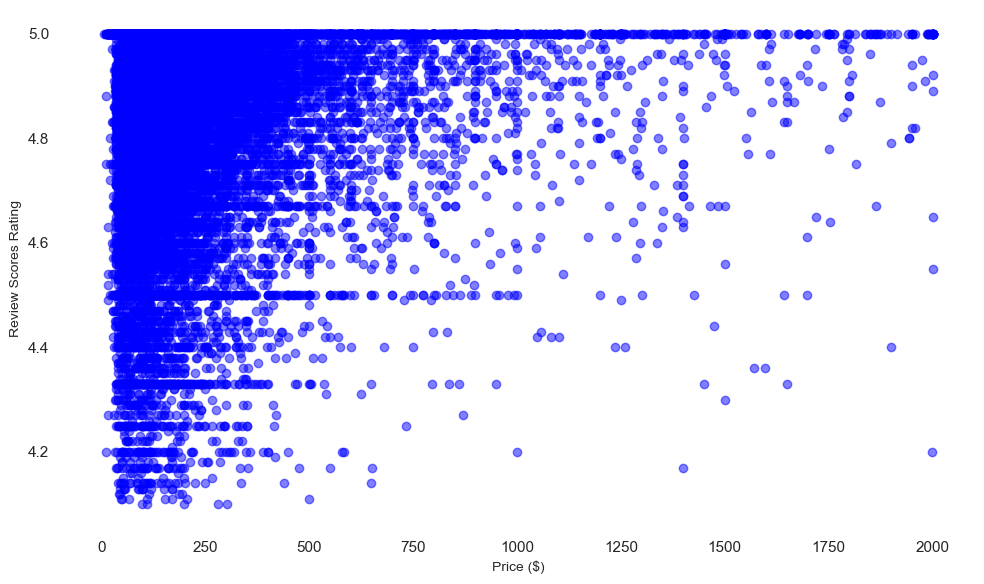

In [74]:
filtered_data = data_nologprice[(data_nologprice["price"] >= 0) & (data_nologprice["price"] <= 2000) & (data_nologprice['review_scores_rating'] >= 4.1)]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['price'], filtered_data['review_scores_rating'], alpha=0.5, color='blue')

plt.xlabel('Price ($)', fontsize=10)
plt.ylabel('Review Scores Rating', fontsize=10)

plt.box(False)
plt.grid(False) 

plt.tight_layout()
plt.show()

## ML Deployment & Hyperparameter Tuning

#### Defining functions for the ML pipeline

In [75]:
imputer = IterativeImputer(random_state = 42, max_iter = 1)

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaled_continuous', Pipeline(steps=[
            ('imputer', imputer),
            ('scaler', StandardScaler())
        ]), continuous_features_std),

        ('minmax_scaled_continuous', Pipeline(steps=[
            ('imputer', imputer),
            ('scaler', MinMaxScaler())
        ]), continuous_features_minmax),

        ('categorical', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first')),
        ]), categorical_features),
    ],
    remainder='passthrough',
    verbose=True
)

In [76]:
def train_and_evaluate(X, y, preprocessor, model, param_grid, groups, nr_states):
    """
    Train and evaluate models using GroupShuffleSplit and GroupKFold based on group labels.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.ndarray): Target variable.
        preprocessor (ColumnTransformer): Preprocessing pipeline.
        model (Estimator): Initialized machine learning model.
        param_grid (dict): Parameter grid for GridSearchCV.
        groups (pd.Series or np.ndarray): Group labels for each sample.
        nr_states (int): Number of random states for repeated splits.

    Returns:
        list: List of test R² scores.
        list: List of trained models from GridSearchCV.
        pd.DataFrame: DataFrame containing train and validation R² for each fold.
    """
    test_r2_scores = []
    final_models = []
    all_cv_results = []

    for state in range(nr_states):
        print(f"\nProcessing Random State {state + 1}")

        print("Performing group-aware train-test split...")
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42 * state)
        train_idx, test_idx = next(gss.split(X, y, groups=groups))
        X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        train_groups = groups.iloc[train_idx]

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        print("Starting GridSearchCV with GroupKFold...")
        group_kfold = GroupKFold(n_splits=5)
        grid_search = GridSearchCV(
            pipe,
            param_grid,
            cv=group_kfold.split(X_train_raw, y_train, groups=train_groups),
            scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},  
            refit='r2',  
            n_jobs=-1,
            verbose=2
        )

        try:
            grid_search.fit(X_train_raw, y_train)
            print("GridSearchCV completed successfully.")
        except Exception as error:
            print(f"Error during GridSearchCV: {error}")
            raise

        best_model = grid_search.best_estimator_
        best_neg_mse = grid_search.best_score_  
        best_mse = -best_neg_mse  
        best_rmse = best_mse ** 0.5  

        mean_r2_score = np.mean(grid_search.cv_results_['mean_test_r2'])

        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best CV Negative MSE: {best_neg_mse:.4f}")
        print(f"Best CV RMSE: {best_rmse:.4f}")
        print(f"Mean CV R²: {mean_r2_score:.4f}")

        print("Evaluating best model on the test set...")
        try:
            target_predictions = best_model.predict(X_test_raw)
            test_mse = mean_squared_error(y_test, target_predictions)
            test_rmse = test_mse ** 0.5
            test_r2_score = r2_score(y_test, target_predictions)
        except Exception as error:
            print(f"Error during test set evaluation: {error}")
            raise

        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test R²: {test_r2_score:.4f}")

        test_r2_scores.append(test_r2_score)  
        final_models.append(best_model)

        results_df = pd.DataFrame(grid_search.cv_results_)
        results_df['random_state'] = state
        all_cv_results.append(results_df)

    print("Combining all cross-validation results...")
    combined_cv_results = pd.concat(all_cv_results, ignore_index=True)
    print("Model training and evaluation complete.")

    return test_r2_scores, final_models, combined_cv_results


#### Executing the pipeline across ML models

In [ ]:
results = {}

models = {
    'xgboost': (
        XGBRegressor(random_state=42), 
        {
            'model__max_depth': [2, 7, 10],
            'model__learning_rate': [0.2, 0.25, 0.3],
        }
    ),
    'decision_tree': (
        DecisionTreeRegressor(random_state=42),
        {
            'model__max_depth': [5, 6, 7],
            'model__max_features': [320, 330, 340],
        }
    ),
    'random_forest': (
        RandomForestRegressor(random_state=42), 
        { 
            'model__max_depth': [20, 30, 40],
            'model__max_features': [100, 125, 150],
        }
    ),
    'ridge_regression': (
        Ridge(random_state=42),
        {
            'model__alpha': [8, 10, 12],
        }
    ),
}

for model_name, (model, param_grid) in models.items():
    print(f"\nTraining {model_name}")
    
    test_r2_scores, final_models, _ = train_and_evaluate(
        X=X,
        preprocessor=preprocessor, 
        y=y,
        model=model,
        param_grid=param_grid,
        groups=groups,
        nr_states=5, 
    )
    
    mean_r2 = np.mean(test_r2_scores)
    std_r2 = np.std(test_r2_scores)

    results[model_name] = {
        'mean_r2': mean_r2,
        'std_r2': std_r2,
        'test_r2_scores': test_r2_scores,
        'models': final_models
    }

    print(f"{model_name} Results:")
    print(f"Mean R²: {mean_r2:.4f}")
    print(f"Std R²: {std_r2:.4f}")

print("\nModel Performance Summary:")
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Mean R²: {result['mean_r2']:.4f}")
    print(f"  Std R²: {result['std_r2']:.4f}")

best_model_name = max(results, key=lambda x: results[x]['mean_r2'])
best_model = results[best_model_name]['models']

print("\nBest Model:", best_model_name)
print(f"Mean R²: {results[best_model_name]['mean_r2']:.4f}")
print(f"Std R²: {results[best_model_name]['std_r2']:.4f}")

## Results

#### Baseline Vs Predicted Accuracy

In [ ]:
model_names = list(results.keys())
mean_r2 = [results[model]['mean_r2'] for model in model_names]
std_r2 = [results[model]['std_r2'] for model in model_names]

plt.figure(figsize=(12, 6))
x_positions = np.arange(len(model_names))

plt.errorbar(
    x_positions,
    mean_r2,
    yerr=std_r2,
    fmt='o',
    capsize=5,
    label='Model Mean R2 (With STD)'
)

for i, (mean, std) in enumerate(zip(mean_r2, std_r2)):
    plt.text(
        x_positions[i],
        mean + 0.02, 
        f"Mean: {mean:.3f}\nSTD: {std:.3f}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.xticks(x_positions, model_names, rotation=45)
plt.ylabel("R2")
plt.title("Model R2 vs Baseline")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.00)
plt.show()

#### Global Feature Importance

In [78]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
train_groups = groups.iloc[train_idx]

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(max_depth=7, learning_rate=0.2, random_state=42))
])

pipe.fit(X_train_raw, y_train)

y_pred = pipe.predict(X_test_raw)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")

c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (1 of 4) Processing std_scaled_continuous, total=   0.1s


c:\Users\mdall\anaconda3\envs\DATA1030\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[ColumnTransformer]  (2 of 4) Processing minmax_scaled_continuous, total=   0.5s
[ColumnTransformer] ... (3 of 4) Processing categorical, total=   0.1s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s
R2 Score: 0.7087


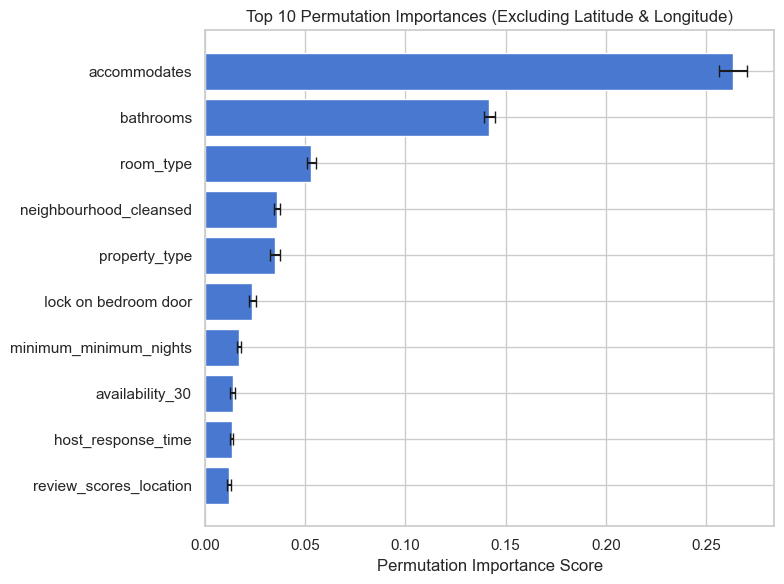

                    feature  importance_mean  importance_std
6              accommodates         0.263598        0.006878
7                 bathrooms         0.141771        0.002746
5                 room_type         0.052964        0.002227
3    neighbourhood_cleansed         0.035985        0.001545
4             property_type         0.034716        0.002470
..                      ...              ...             ...
85          central heating        -0.000277        0.000090
61                  toaster        -0.000336        0.000059
100     ethernet connection        -0.000345        0.000230
107             board games        -0.000380        0.001033
133            first_review        -0.001154        0.000519

[136 rows x 3 columns]


In [79]:
perm_importance = permutation_importance(
    pipe, X_test_raw, y_test, n_repeats=10, random_state=42, scoring='r2'
)

importance_results = pd.DataFrame({
    "feature": X_test_raw.columns,
    "importance_mean": perm_importance.importances_mean,
    "importance_std": perm_importance.importances_std
}).sort_values(by="importance_mean", ascending=False)

filtered_features = importance_results[~importance_results['feature'].isin(['longitude', 'latitude'])]
top_features = filtered_features.head(10)

plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'], top_features['importance_mean'], xerr=top_features['importance_std'], capsize=4)
plt.title("Top 10 Permutation Importances (Excluding Latitude & Longitude)")
plt.xlabel("Permutation Importance Score")
plt.gca().invert_yaxis()
plt.grid(False)
plt.tight_layout()
plt.show()

print(importance_results)

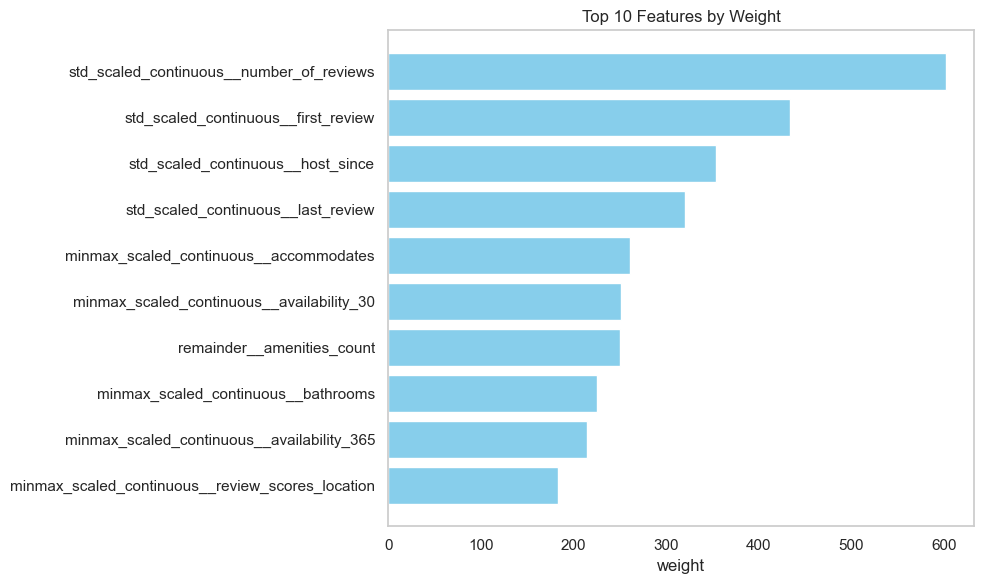

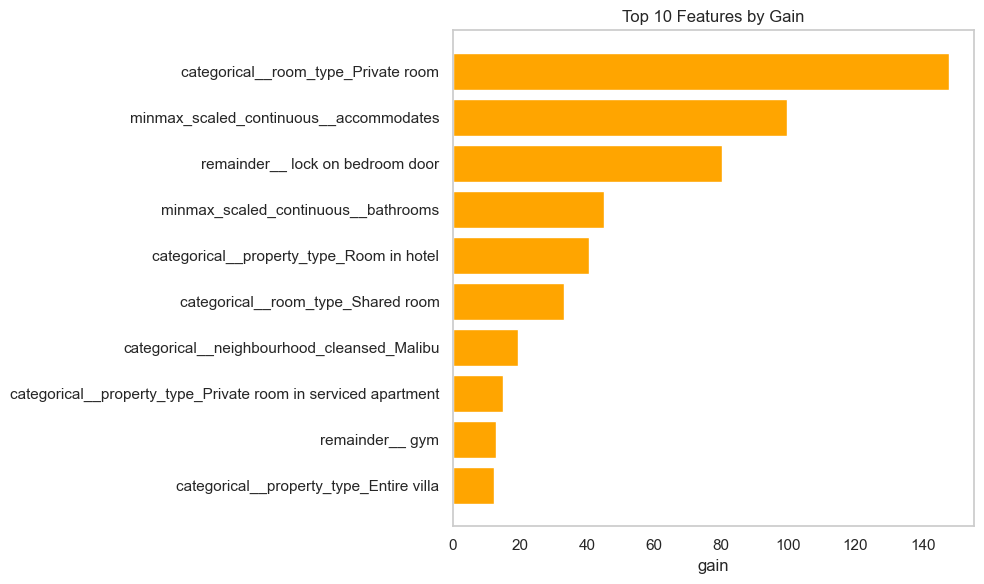

In [80]:
importance_metrics = ['weight', 'gain']

xgb_model = pipe.named_steps['model']

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()

importance = {
    metric: xgb_model.get_booster().get_score(importance_type=metric) for metric in importance_metrics
}

data = []
for metric, values in importance.items():
    for f, value in values.items():
        data.append({'Feature': feature_names[int(f[1:])], 'Metric': metric, 'Value': value})

feature_importance_df = pd.DataFrame(data)

def plot_top_features(df, metric, color):
    top_features = df[df['Metric'] == metric].sort_values(by='Value', ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'][::-1], top_features['Value'][::-1], align='center', color=color)
    plt.xlabel(metric)
    plt.title(f'Top 10 Features by {metric.capitalize()}')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

colors = ['skyblue', 'orange', 'green', 'purple', 'red']  
for metric, color in zip(importance_metrics, colors):
    plot_top_features(feature_importance_df, metric=metric, color=color)


#### Predicted Vs Actual Values Scatter Plot

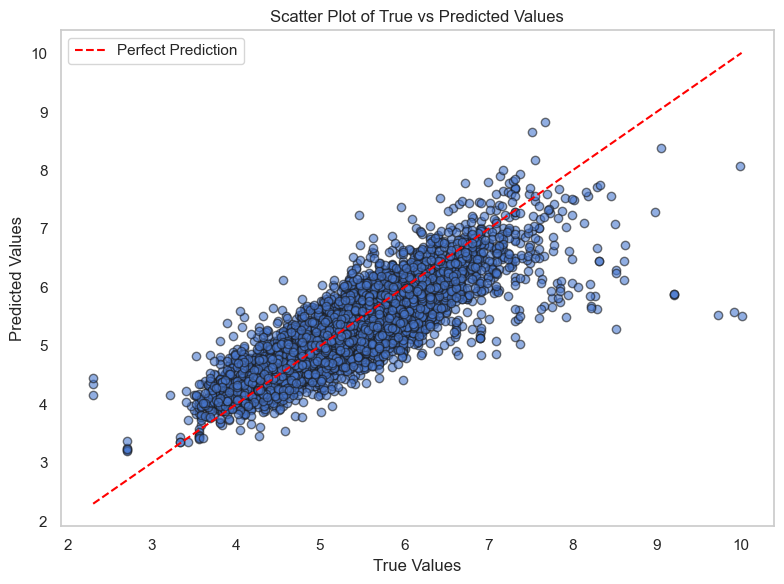

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title("Scatter Plot of True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

#### Local Feature Importance

Waterfall plot for Point 1 (Index: 18880):


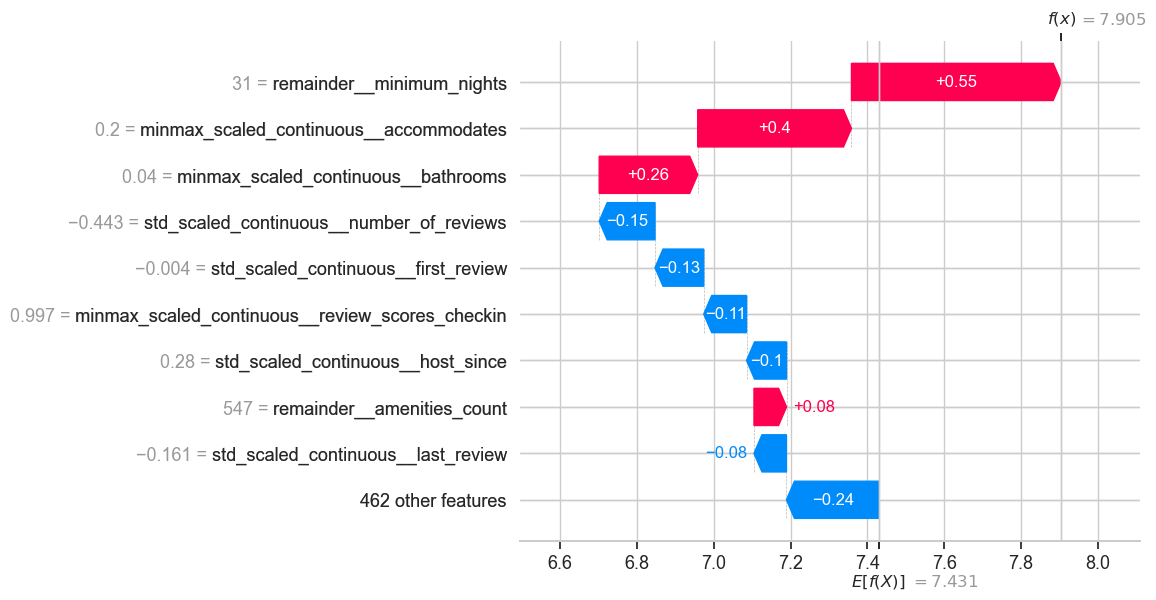

Waterfall plot for Point 2 (Index: 31209):


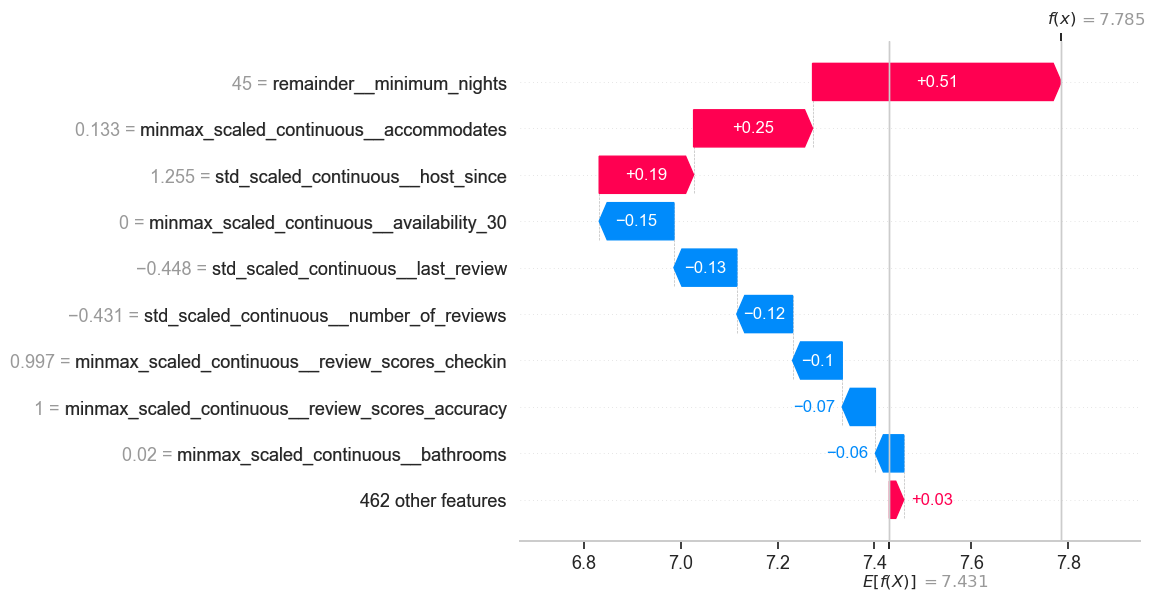

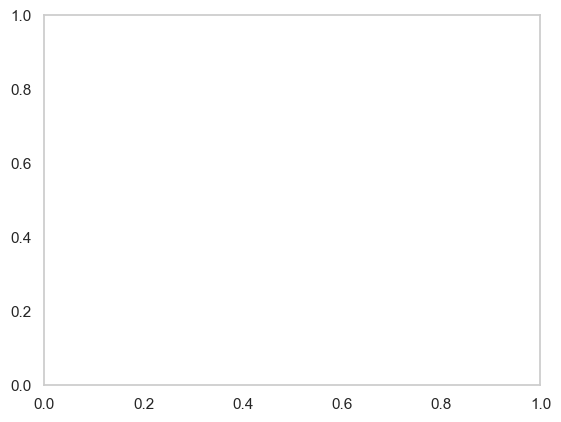

In [82]:
random_indices = np.random.choice(X_test_raw.index, size=2, replace=False)
X_sample = X_test_raw.loc[random_indices]

X_train_preprocessed = pipe.named_steps['preprocessor'].transform(X_train_raw).toarray()
X_sample_preprocessed = pipe.named_steps['preprocessor'].transform(X_sample).toarray()

preprocessed_feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.Explainer(pipe.named_steps['model'], X_train_preprocessed, feature_names=preprocessed_feature_names)

shap_values = explainer(X_sample_preprocessed)

for i, index in enumerate(random_indices):
    print(f"Waterfall plot for Point {i + 1} (Index: {index}):")
    shap.plots.waterfall(shap_values[i])
    plt.grid(False)